In [6]:
%pip install requests tensorflow[and-cuda] aria2 netCDF4 numpy xarray scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 20.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 22.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 23.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 23.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

# Constants
DOWNLOAD_DATA = True
DATA_DIR = './data'  # Directory containing .tar.gz files
EXTRACT_DIR = os.path.join(DATA_DIR, 'extracted')
TRAIN_DIR = "./data/extracted/train"
TEST_DIR = "./data/extracted/test"
TRAIN_OUTPUT_DIR = "./data/tfrecords/train"
TEST_OUTPUT_DIR = "./data/tfrecords/test"

In [8]:
import logging
import subprocess
import tarfile

# Setup logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")

# Bucket and endpoint configuration
CUSTOM_ENDPOINT = "bbproxy.meyerstk.com/file"
APP = "TorNetBecauseZenodoSlow"
TMP_FILE = os.path.join(DATA_DIR, "tmp.txt")

# Ensure directories exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(EXTRACT_DIR, exist_ok=True)


def download_links(links):
    """
    Download files from the provided links using aria2c.
    Uses a file named tmp.txt in DATA_DIR for links.
    """
    try:
        # Write links to tmp.txt
        with open(TMP_FILE, 'w') as file:
            file.writelines(link + '\n' for link in links)
        logging.info(f"Temporary file created: {TMP_FILE}")

        # Run aria2c to download files
        logging.info(f"Starting downloads for links: {', '.join(links)}")
        command = [
            "aria2c",
            "-j", "5",                # Download up to 3 files concurrently
            "-x", "16",               # Use up to 16 connections per file
            # "--console-log-level=info",
            "-s", "16",               # Split each file into 16 segments
            "--dir", DATA_DIR,        # Specify the download directory
            "-i", TMP_FILE            # Input file with download links
        ]
        subprocess.run(command, check=True)
        logging.info("Downloads completed successfully.")
    except Exception as e:
        logging.error(f"Error during download: {e}")
        exit(1)
    finally:
        if os.path.exists(TMP_FILE):
            os.remove(TMP_FILE)
            logging.info(f"Temporary file deleted: {TMP_FILE}")


def download_files_with_aria():
    """
    Download files from a public Backblaze B2 bucket served via a custom endpoint using aria2c.
    """
    logging.info("Starting download process with aria2c...")

    # # List of files to download
    file_list = [
        "tornet_2013.tar.gz",
        "tornet_2014.tar.gz",
        "tornet_2015.tar.gz",
        "tornet_2016.tar.gz",
        "tornet_2017.tar.gz",
        "tornet_2018.tar.gz",
        "tornet_2019.tar.gz",
        "tornet_2020.tar.gz",
        "tornet_2021.tar.gz",
        "tornet_2022.tar.gz",
        "catalog.csv"
    ]

    # Construct the public URLs
    links = [f"https://{CUSTOM_ENDPOINT}/{APP}/{file_name}" for file_name in file_list]
    
    # Filter out already downloaded files
    links_to_download = [
        link for link in links
        if not os.path.exists(os.path.join(DATA_DIR, os.path.basename(link)))
    ]

    if links_to_download:
        download_links(links_to_download)
    else:
        logging.info("All files already downloaded.")


def extract_local_tar_files():
    """
    Extract all .tar.gz files from the local DATA_DIR to EXTRACT_DIR.
    """
    logging.info("Starting extraction process...")
    for file_name in os.listdir(DATA_DIR):
        if file_name.endswith('.tar.gz'):
            file_path = os.path.join(DATA_DIR, file_name)
            logging.info(f'Extracting {file_path}...')
            with tarfile.open(file_path, 'r:gz') as tar:
                tar.extractall(path=EXTRACT_DIR)
            logging.info(f'Extracted {file_path} to {EXTRACT_DIR}')

            os.remove(file_path)

if DOWNLOAD_DATA:
    download_files_with_aria()
    extract_local_tar_files()

2024-12-05 12:35:31,524 - INFO - Starting download process with aria2c...
2024-12-05 12:35:31,526 - INFO - Temporary file created: ./data/tmp.txt
2024-12-05 12:35:31,528 - INFO - Starting downloads for links: https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2013.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2014.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2015.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2016.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2017.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2018.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2019.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2020.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2021.tar.gz, https://bbproxy.meyerstk.com/file/TorNetBecauseZenodoSlow/tornet_2022.tar.gz, https://bbp


12/05 12:35:31 [NOTICE] Downloading 11 item(s)
[DL:2.7MiB][#35532d 336KiB/2.9GiB(0%)][#5c6ff8 464KiB/14GiB(0%)][#eae94b 0B/16GiB(0%)][#94a5b4 0B/0B][#0c395a 0B/0B] [FileAlloc:#eae94b 0B/16GiB(0%)]
[DL:126MiB][#35532d 66MiB/2.9GiB(2%)][#5c6ff8 54MiB/14GiB(0%)][#eae94b 23MiB/16GiB(0%)][#94a5b4 4.9MiB/15GiB(0%)][#0c395a 13MiB/14GiB(0%)]
[DL:201MiB][#35532d 147MiB/2.9GiB(4%)][#5c6ff8 136MiB/14GiB(0%)][#eae94b 70MiB/16GiB(0%)][#94a5b4 43MiB/15GiB(0%)][#0c395a 58MiB/14GiB(0%)]
[DL:238MiB][#35532d 212MiB/2.9GiB(7%)][#5c6ff8 201MiB/14GiB(1%)][#eae94b 135MiB/16GiB(0%)][#94a5b4 108MiB/15GiB(0%)][#0c395a 122MiB/14GiB(0%)]
[DL:262MiB][#35532d 280MiB/2.9GiB(9%)][#5c6ff8 269MiB/14GiB(1%)][#eae94b 203MiB/16GiB(1%)][#94a5b4 176MiB/15GiB(1%)][#0c395a 189MiB/14GiB(1%)]
[DL:276MiB][#35532d 347MiB/2.9GiB(11%)][#5c6ff8 335MiB/14GiB(2%)][#eae94b 269MiB/16GiB(1%)][#94a5b4 242MiB/15GiB(1%)][#0c395a 256MiB/14GiB(1%)]
[DL:286MiB][#35532d 415MiB/2.9GiB(13%)][#5c6ff8 403MiB/14GiB(2%)][#eae94b 337MiB/16GiB(2%)][#

2024-12-05 12:42:31,867 - INFO - Downloads completed successfully.
2024-12-05 12:42:31,869 - INFO - Temporary file deleted: ./data/tmp.txt
2024-12-05 12:42:31,871 - INFO - Starting extraction process...
2024-12-05 12:42:31,873 - INFO - Extracting ./data/tornet_2014.tar.gz...


[#c39536 17GiB/17GiB(99%) CN:7 DL:240MiB]

12/05 12:42:31 [NOTICE] Download complete: ./data/tornet_2022.tar.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
35532d|OK  |    65MiB/s|./data/tornet_2013.tar.gz
0c395a|OK  |    67MiB/s|./data/tornet_2017.tar.gz
5c6ff8|OK  |    66MiB/s|./data/tornet_2014.tar.gz
25ec3b|OK  |    69MiB/s|./data/tornet_2018.tar.gz
94a5b4|OK  |    69MiB/s|./data/tornet_2016.tar.gz
eae94b|OK  |    69MiB/s|./data/tornet_2015.tar.gz
562979|OK  |   5.2MiB/s|./data/catalog.csv
7e71b7|OK  |    90MiB/s|./data/tornet_2019.tar.gz
26bd24|OK  |    82MiB/s|./data/tornet_2020.tar.gz
0d41b4|OK  |    89MiB/s|./data/tornet_2021.tar.gz
c39536|OK  |    92MiB/s|./data/tornet_2022.tar.gz

Status Legend:
(OK):download completed.


2024-12-05 12:43:39,483 - INFO - Extracted ./data/tornet_2014.tar.gz to ./data/extracted
2024-12-05 12:43:40,675 - INFO - Extracting ./data/tornet_2013.tar.gz...
2024-12-05 12:43:56,372 - INFO - Extracted ./data/tornet_2013.tar.gz to ./data/extracted
2024-12-05 12:43:56,512 - INFO - Extracting ./data/tornet_2015.tar.gz...
2024-12-05 12:45:16,256 - INFO - Extracted ./data/tornet_2015.tar.gz to ./data/extracted
2024-12-05 12:45:17,584 - INFO - Extracting ./data/tornet_2017.tar.gz...
2024-12-05 12:46:23,002 - INFO - Extracted ./data/tornet_2017.tar.gz to ./data/extracted
2024-12-05 12:46:23,695 - INFO - Extracting ./data/tornet_2016.tar.gz...
2024-12-05 12:47:25,100 - INFO - Extracted ./data/tornet_2016.tar.gz to ./data/extracted
2024-12-05 12:47:25,843 - INFO - Extracting ./data/tornet_2018.tar.gz...
2024-12-05 12:48:13,792 - INFO - Extracted ./data/tornet_2018.tar.gz to ./data/extracted
2024-12-05 12:48:14,386 - INFO - Extracting ./data/tornet_2019.tar.gz...
2024-12-05 12:49:33,946 - IN

In [26]:
import numpy as np
import xarray as xr
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict, Counter

# Constants for normalization
CHANNEL_MIN_MAX = {
    'DBZ': [-20., 60.],
    'VEL': [-60., 60.],
    'KDP': [-2., 5.],
    'RHOHV': [0.2, 1.04],
    'ZDR': [-1., 8.],
    'WIDTH': [0., 9.]
}

VARIABLES = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

def parse_nc_file(file_path):
    """
    Parse and preprocess a single .nc file.
    Output: features (4D array), label (int)
    """
    try:
        with xr.open_dataset(file_path, engine="netcdf4") as ds:
            data_list = []

            # Process radar variables
            for var in VARIABLES:
                if var not in ds:
                    raise ValueError(f"Variable {var} not found in dataset.")

                var_data = ds[var].values  # Shape: [time, azimuth, range, sweep]
                var_min, var_max = CHANNEL_MIN_MAX[var]

                # Handle missing data and normalize
                var_data = np.nan_to_num(var_data, nan=0, posinf=0, neginf=0)
                var_data[var_data == ds.attrs.get('MissingDataFlag', -999.0)] = 0
                var_data = np.clip(var_data, var_min, var_max)
                var_data = (var_data - var_min) / (var_max - var_min)
                var_data = (var_data * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

                data_list.append(var_data)

            # Combine variables into the channel dimension
            data = np.stack(data_list, axis=-1)  # Shape: [time, azimuth, range, sweep, variables]
            data = data.transpose(0, 1, 2, 4, 3)  # [time, azimuth, range, variables, sweep]
            data = data.reshape(data.shape[0], data.shape[1], data.shape[2], -1)  # [time, azimuth, range, channels]

            # Ensure correct time dimension
            if data.shape[0] < 4:
                raise ValueError(f"File {file_path} has fewer than 4 time steps.")

            # Extract label from category attribute
            label = ds.attrs.get("category", "NUL")
            label = 1 if label == "TOR" else 0

            return data[:4], label  # Return first 4 time steps

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

def serialize_example(features, label):
    """
    Serialize features and labels into a TFRecord-compatible format.
    """
    feature = {
        "features": tf.train.Feature(bytes_list=tf.train.BytesList(value=[features.tobytes()])),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

def group_files_by_year(input_dir):
    """
    Group `.nc` files by year.
    """
    files_by_year = defaultdict(list)
    
    for file in Path(input_dir).rglob("*.nc"):
        year = file.parent.name  # Assuming year is the folder name
        
        if year == "2013":  # Keep only files from the year "2013"
            files_by_year[year].append(file)

    return files_by_year

def process_year(year, files, output_dir):
    """
    Process files for a given year and save them as a TFRecord file.
    """
    output_path = str(Path(output_dir) / f"{year}.tfrecord")
    local_label_counts = Counter()  # Local Counter for this process
    
    with tf.io.TFRecordWriter(output_path) as writer:
        for file in tqdm(files, desc=f"Processing year {year}"):
            features, label = parse_nc_file(file)
            if features is not None:
                example = serialize_example(features, label)
                writer.write(example)
                local_label_counts[label] += 1  # Update local counts

    print(f"Completed {year}: {len(files)} files")
    return local_label_counts 
    
def create_tfrecords(input_dir, output_dir, num_workers=4):
    """
    Create TFRecords for all years in train/test directories in parallel.
    Aggregate label counts from all processes.
    """
    os.makedirs(output_dir, exist_ok=True)
    files_by_year = group_files_by_year(input_dir)

    total_label_counts = Counter()  # Global Counter for all processes

    # Process each year in parallel
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [
            executor.submit(process_year, year, files, output_dir)
            for year, files in files_by_year.items()
        ]
        for future in tqdm(futures, desc="Processing all years"):
            year_label_counts = future.result()  # Get label counts from process
            total_label_counts.update(year_label_counts)  # Aggregate counts
    
    return total_label_counts

# Create TFRecords
print("Creating training TFRecords...")
train_counts = create_tfrecords(TRAIN_DIR, TRAIN_OUTPUT_DIR, num_workers=50)

print("Creating testing TFRecords...")
test_counts = create_tfrecords(TEST_DIR, TEST_OUTPUT_DIR, num_workers=50)

total_label_counts = train_counts + test_counts
print(f"Total Label Counts: {total_label_counts}")

Creating training TFRecords...


Processing year 2013: 100%|██████████| 3498/3498 [04:08<00:00, 14.07it/s]


Completed 2013: 3498 files


Processing all years: 100%|██████████| 1/1 [04:09<00:00, 249.19s/it]


Creating testing TFRecords...


Processing year 2013: 100%|██████████| 573/573 [00:40<00:00, 13.99it/s]


Completed 2013: 573 files


Processing all years: 100%|██████████| 1/1 [00:41<00:00, 41.09s/it]


Total Label Counts: Counter({0: 3682, 1: 389})


In [9]:
def parse_tfrecord(example):
    feature_description = {
        "features": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)

    # Decode features and reshape directly to the known fixed shape
    features = tf.io.decode_raw(parsed_example["features"], tf.uint8)
    features = tf.reshape(features, [4, 120, 240, 12])  # Directly use the fixed shape
    features = tf.cast(features, tf.float32) / 255.0  # Scale back to [0, 1]

    # Parse label
    label = tf.cast(parsed_example["label"], tf.float32)
    label = tf.reshape(label, (1,))  # Ensure label has shape [1]

    return features, label

def create_tf_dataset_with_count(tfrecord_dir, batch_size, shuffle=True):
    """
    Create a tf.data.Dataset from TFRecord files and count total samples.
    """
    tfrecord_files = list(Path(tfrecord_dir).glob("*.tfrecord"))
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    sample_count = 0
    for record in dataset:
        sample_count += 1

    dataset = dataset.map(parse_tfrecord)
    if shuffle:
        dataset = dataset.shuffle(1000)
    
    batch_size *= strategy.num_replicas_in_sync
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    dataset = dataset.repeat()
    
    return dataset, sample_count

BATCH_SIZE = 32

train_dataset, train_sample_count = create_tf_dataset_with_count(TRAIN_OUTPUT_DIR, batch_size=BATCH_SIZE)
test_dataset, test_sample_count = create_tf_dataset_with_count(TEST_OUTPUT_DIR, batch_size=BATCH_SIZE, shuffle=False)

train_steps_per_epoch = np.ceil(train_sample_count / BATCH_SIZE).astype(int)
validation_steps = np.ceil(test_sample_count / BATCH_SIZE).astype(int)

print(f"Train samples: {train_sample_count} (Steps: {train_steps_per_epoch}), Test samples: {test_sample_count} (Steps: {validation_steps})")

for features, labels in train_dataset.take(1):
    print(f"Feature shape: {features.shape}, Label shape: {labels.shape}")

Train samples: 3498 (Steps: 110), Test samples: 573 (Steps: 18)
Feature shape: (128, 4, 120, 240, 12), Label shape: (128, 1)


In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models, layers

def create_3d_torcnn(input_shape=(4, 120, 240, 12), dropout_rate=0.2):
    """
    Define a 3D CNN model for tornado detection with advanced optimizations.
    """
    model = models.Sequential(
        [
            # Input Layer
            layers.Input(shape=input_shape),
            
            # Block 1
            layers.Conv3D(32, (3, 3, 3), padding="same", kernel_regularizer=l2(0.01)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Conv3D(32, (3, 3, 3), padding="same", kernel_regularizer=l2(0.01)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.MaxPooling3D((1, 2, 2)),
            layers.SpatialDropout3D(dropout_rate),

            # Block 2
            layers.Conv3D(64, (3, 3, 3), padding="same", kernel_regularizer=l2(0.01)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Conv3D(64, (3, 3, 3), padding="same", kernel_regularizer=l2(0.01)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.MaxPooling3D((1, 2, 2)),
            layers.SpatialDropout3D(dropout_rate),

            # Block 3
            layers.Conv3D(128, (3, 3, 3), padding="same", kernel_regularizer=l2(0.01)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Conv3D(128, (3, 3, 3), padding="same", kernel_regularizer=l2(0.01)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.MaxPooling3D((2, 2, 2)),
            layers.SpatialDropout3D(dropout_rate),

            # Global Pooling
            layers.GlobalMaxPooling3D(),

            # Fully Connected Layers
            layers.Dense(128, kernel_regularizer=l2(0.01)),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

    return model

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tornado (1), Storm (0)
labels = [0, 1]
counts = [total_label_counts[0], total_label_counts[1]]

# Convert classes to a NumPy array
classes = np.array(labels)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.repeat(classes, counts))

# Convert to dictionary for TensorFlow
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class Weights: {class_weight_dict}")

2024-12-05 16:29:55,413 - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Number of devices: 4
Class Weights: {0: np.float64(0.5528245518739815), 1: np.float64(5.232647814910026)}


In [ ]:
# Create a MirroredStrategy for multiple GPUs
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

# Build and compile the model within the strategy scope
with strategy.scope():
    model = create_3d_torcnn()
    model.compile(
        optimizer=Adam(learning_rate=0.0005, clipvalue=1.0),  # Gradient clipping
        loss=BinaryCrossentropy(from_logits=False),
        metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]
    )

history = model.fit(
    train_dataset,
    epochs=50,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
    ]
)

2024-12-05 16:30:40,394 - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Number of devices: 4


2024-12-05 16:30:42,390 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-12-05 16:30:43,231 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-12-05 16:30:43,233 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/50


2024-12-05 16:30:47,002 - INFO - Collective all_reduce tensors: 28 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
I0000 00:00:1733416255.042555    4373 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733416255.043848    4375 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733416255.213554    4372 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733416255.268055    4374 cuda_dnn.cc:529] Loaded cuDNN version 90300


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5277 - auc: 0.5565 - loss: 5.8330 - precision: 0.1081 - recall: 0.5518

2024-12-05 16:31:38,625 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-12-05 16:31:40,765 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


110/110 ━━━━━━━━━━━━━━━━━━━━ 71s 476ms/step - accuracy: 0.5284 - auc: 0.5571 - loss: 5.8286 - precision: 0.1084 - recall: 0.5521 - val_accuracy: 0.8142 - val_auc: 0.6288 - val_loss: 4.3157 - val_precision: 0.0784 - val_recall: 0.0625 - learning_rate: 5.0000e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7491 - auc: 0.8321 - loss: 3.9728 - precision: 0.2442 - recall: 0.7445

2024-12-05 16:32:27,387 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-12-05 16:32:28,110 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 328ms/step - accuracy: 0.7493 - auc: 0.8323 - loss: 3.9697 - precision: 0.2444 - recall: 0.7448 - val_accuracy: 0.7865 - val_auc: 0.6514 - val_loss: 3.0485 - val_precision: 0.0317 - val_recall: 0.0312 - learning_rate: 5.0000e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7898 - auc: 0.8730 - loss: 2.7898 - precision: 0.2891 - recall: 0.7983

2024-12-05 16:33:03,457 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-12-05 16:33:04,131 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 327ms/step - accuracy: 0.7898 - auc: 0.8731 - loss: 2.7878 - precision: 0.2890 - recall: 0.7986 - val_accuracy: 0.8229 - val_auc: 0.7229 - val_loss: 2.1577 - val_precision: 0.1231 - val_recall: 0.1509 - learning_rate: 5.0000e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8170 - auc: 0.9026 - loss: 2.0217 - precision: 0.3245 - recall: 0.8429

2024-12-05 16:33:39,144 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.8172 - auc: 0.9028 - loss: 2.0203 - precision: 0.3246 - recall: 0.8431 - val_accuracy: 0.7622 - val_auc: 0.4917 - val_loss: 1.7783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - accuracy: 0.8226 - auc: 0.9079 - loss: 1.5823 - precision: 0.3267 - recall: 0.8440 - val_accuracy: 0.8368 - val_auc: 0.5318 - val_loss: 1.4133 - val_precision: 0.1613 - val_recall: 0.1923 - learning_rate: 5.0000e-04
Epoch 6/50
101/110 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.8352 - auc: 0.9165 - loss: 1.3110 - precision: 0.3480 - recall: 0.8492

2024-12-05 16:34:49.819231: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 326ms/step - accuracy: 0.8358 - auc: 0.9170 - loss: 1.3051 - precision: 0.3493 - recall: 0.8506 - val_accuracy: 0.7535 - val_auc: 0.7317 - val_loss: 1.2808 - val_precision: 0.2532 - val_recall: 0.6250 - learning_rate: 5.0000e-04
Epoch 7/50
 20/110 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - accuracy: 0.8561 - auc: 0.9345 - loss: 1.1055 - precision: 0.3736 - recall: 0.8838

2024-12-05 16:35:01.543372: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 326ms/step - accuracy: 0.8511 - auc: 0.9345 - loss: 1.0816 - precision: 0.3713 - recall: 0.8818 - val_accuracy: 0.7031 - val_auc: 0.9327 - val_loss: 1.3195 - val_precision: 0.2704 - val_recall: 0.9844 - learning_rate: 5.0000e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8615 - auc: 0.9345 - loss: 0.9647 - precision: 0.3883 - recall: 0.8795

2024-12-05 16:36:04.524133: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 332ms/step - accuracy: 0.8615 - auc: 0.9345 - loss: 0.9644 - precision: 0.3881 - recall: 0.8796 - val_accuracy: 0.9062 - val_auc: 0.8102 - val_loss: 0.8857 - val_precision: 0.5000 - val_recall: 0.5370 - learning_rate: 5.0000e-04
Epoch 9/50
  2/110 ━━━━━━━━━━━━━━━━━━━━ 34s 322ms/step - accuracy: 0.9238 - auc: 0.9678 - loss: 0.8359 - precision: 0.5306 - recall: 0.8884

2024-12-05 16:36:08.971064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 20/110 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.8885 - auc: 0.9510 - loss: 0.8703 - precision: 0.4629 - recall: 0.8832

2024-12-05 16:36:13.856255: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 38/110 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.8728 - auc: 0.9461 - loss: 0.8778 - precision: 0.4269 - recall: 0.8810

2024-12-05 16:36:19.031854: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 57/110 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.8696 - auc: 0.9459 - loss: 0.8729 - precision: 0.4178 - recall: 0.8835

2024-12-05 16:36:24.598437: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 74/110 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.8685 - auc: 0.9458 - loss: 0.8693 - precision: 0.4144 - recall: 0.8845

2024-12-05 16:36:29.826879: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 91/110 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.8680 - auc: 0.9458 - loss: 0.8656 - precision: 0.4124 - recall: 0.8854

2024-12-05 16:36:34.670849: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - accuracy: 0.8677 - auc: 0.9457 - loss: 0.8619 - precision: 0.4112 - recall: 0.8868 - val_accuracy: 0.2708 - val_auc: 0.7750 - val_loss: 2.5112 - val_precision: 0.1030 - val_recall: 0.9600 - learning_rate: 5.0000e-04
Epoch 10/50
  4/110 ━━━━━━━━━━━━━━━━━━━━ 33s 318ms/step - accuracy: 0.8514 - auc: 0.8796 - loss: 1.0158 - precision: 0.4077 - recall: 0.7848

2024-12-05 16:36:44.801280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 707789312 bytes after encountering the first element of size 707789312 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 20/110 ━━━━━━━━━━━━━━━━━━━━ 26s 296ms/step - accuracy: 0.8254 - auc: 0.8950 - loss: 0.9528 - precision: 0.3414 - recall: 0.8362

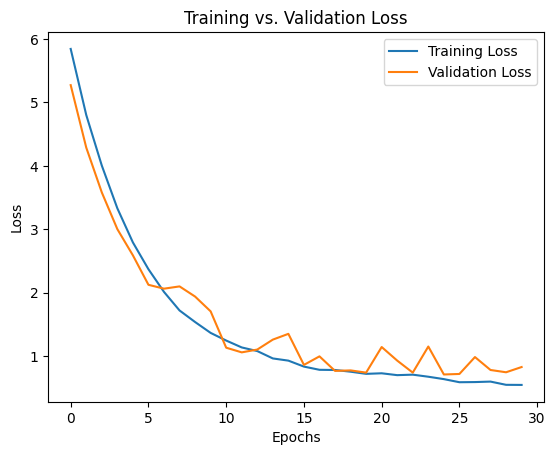

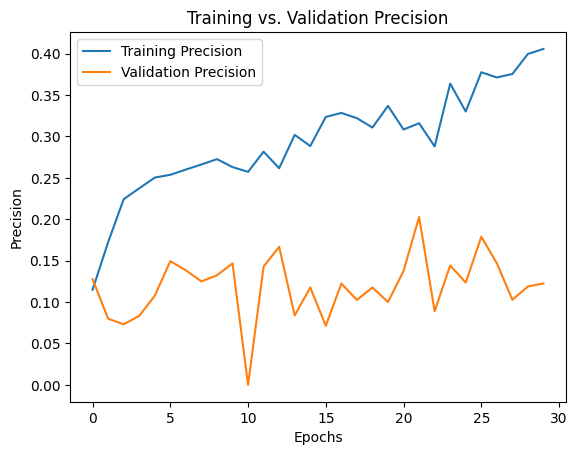

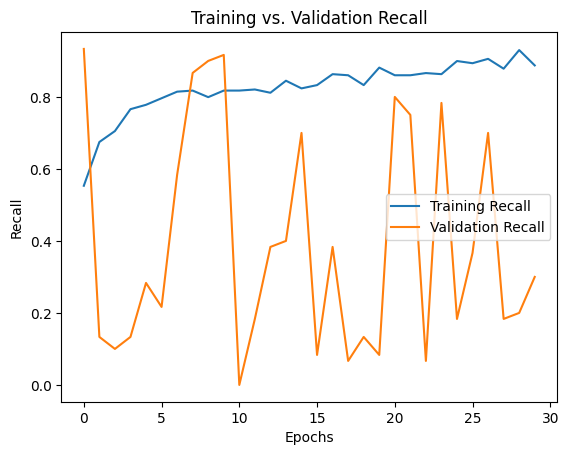

In [42]:
import matplotlib.pyplot as plt

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

# Plot Metrics (e.g., Precision, Recall, AUC)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Training vs. Validation Precision')
plt.show()

plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Training vs. Validation Recall')
plt.show()

In [45]:
import os
from datetime import datetime

# Create a timestamped directory
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"/modelweights/{timestamp}"
os.makedirs(save_path, exist_ok=True)

# Save model weights
model.save_weights(os.path.join(save_path, "model.weights.h5"))
print(f"Model weights saved to {save_path}")

Model weights saved to /modelweights/20241205-161113
